In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


###### Select PROMPT or DISPLACED and set efficiency mode to ETA, D0, or ETASTAR.

In [5]:
############## Are you analyzing PROMPT or DISPLACED muons? ###############
# status = 'prompt'
# status = 'displaced'
status = '2d'
 
############## Which efficiency mode are you analyzing? (Irrelevent if ) ###############
# eff_mode = 'eta'
# eff_mode = 'd0'
eff_mode = 'etastar'

In [6]:
infile_r = None  # input file handle

#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc0.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc1.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc2.0.root'
#infile = '../test7/ntuple_MuMu_FlatPt_PU0_PhaseIITDRSpring19_csc3.0.root'

#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc0.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc1.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc2.0.root'
#infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIITDRSpring19_csc3.0.root'

if status == 'prompt':
    infile = '../test7/ntuple_SingleMuon_Endcap_200k.root'
elif status == 'displaced' or '2d':
    infile = 'ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root'
infile_PU200 = '../test7/ntuple_MuMu_FlatPt_PU200_PhaseIIFall17D_csc0.0.root'

# Takes a collection of events (say, all those with prefix 'vh_') and categorizes them so they are easier to call.
def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def load_pgun_PU200():
  print('[INFO] Opening file: %s' % infile_PU200)
  global infile_r
  infile_r = root_open(infile_PU200)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree


# Function calculates eta of the particle from its eta_star, the eta with which it leaves its vertex
def calc_etastar_from_eta(eta, phi, x0, y0, z0):
  # Propagate to station 2 (z = 850 cm)
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  zstar = 850.
  if eta < 0:
    zstar *= -1
  cot = np.sinh(eta)
  delta_r = np.abs((zstar - z0)/cot)
  xstar = x0 + np.cos(phi) * delta_r
  ystar = y0 + np.sin(phi) * delta_r
  rstar = np.hypot(xstar, ystar)
  cotstar = zstar/rstar
  etastar = np.arcsinh(cotstar)
  return etastar

# Decide the zone which the particle is belong to
def find_particle_zone(part):
  etastar = calc_etastar_from_eta(part.eta, part.phi, part.vx, part.vy, part.vz)
  ind = np.searchsorted(emtf_eta_bins, np.abs(etastar))
  return (4 - ind)  # ind = (1,2,3,4) -> zone (3,2,1,0)

##### Explore the ROOT file and TTree.

In [44]:
# # Open the ROOT file (this object is a TFile)
f1 = ROOT.TFile.Open(infile)
# # Retrieve the tree from the ROOT file (this object is a TTree)
t1 = f1.Get("ntupler/tree")
# # Create a TCanvas, on which to draw the histogram
# c1 = ROOT.TCanvas()
# # t1.Draw("vp_q/vp_pt")
# # c1.SetLogy(True)
# c1.Draw()
# h1 = ROOT.TH1F("h1","vp_vz",100,-30,30)
# # h1.SetLogy(True)
# t1.Draw("vp_vz>>h1","","")
# # axY = h1.GetYaxis()
# # axY.SetLogy()
# h1.Draw("hist e")
# # # c1.Draw()
# # # t1.Show(0)
# # # type(t1)
t1.GetEntries()
# # # infile_s = root_open(infile)
# # # tree_s = infile_s.ntupler.tree
# # # define_collections(tree_s)
# # # tree_s[0].particles[0]

1998000L

In [ ]:
# f1 = ROOT.TFile.Open(infile)
# t1 = f1.Get("ntupler/tree")
# t1.GetEntries()

# Station Information

In [7]:
# Python compatibility module (helps with differences between Python2 and Python3)
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT) stations

stations = ['ME1/1','ME1/2','ME2','ME3','ME4','RE1','RE2','RE3','RE4','GE1','GE2','ME0','MB1','MB2','MB3','MB4']

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99
    # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

# Define Analysis

In [54]:
# Main analysis

def analysis(d0min=0,d0max=0,pileup=0):
  # Load tree
  if pileup == 200:
    tree = load_pgun_PU200()
  else:
    tree = load_pgun()
  
  # Event range
    maxEvents = 1998000
#   maxEvents = 100000
#   maxEvents = 10000
  
  # Output
  out_part, out_hits = [], []
  part_eta, part_etastar, part_d0, part_r_vtx, part_pt = [], [], [], [], []
  
  # __________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    try:
        part = evt.particles[0]  # particle gun
    except IndexError:
        continue
    
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip low pT muons
    if part.pt < 20:
      continue
    
    if status == 'displaced':
        # Skipping high d0 particles
        # d0 is transverse impact parameter
        # R is vertex separation
        if abs(part.d0) > d0max or abs(part.d0) < d0min:
            continue
    
    # Skipping particles whose secondary vertex is too far from beamline
    r_vtx=np.hypot(part.vx,part.vy)
    if status == 'displaced' or status == '2d':
        if r_vtx > 150:
            continue
    
    if status == 'prompt':
        # Skip |eta|<1.2 muons
        if abs(part.eta) < 1.2:
            continue
    elif status == 'displaced' or status == '2d':
        etastar = calc_etastar_from_eta(part.eta, part.phi, part.vx, part.vy, part.vz)
    
#     # Use positive endcap only
#     f = lambda hit: hit.endcap == 1
#     selected_hits = filter(f, evt.hits)
    selected_hits = evt.hits
    
    # Use sim_tp == 1 only
    f = lambda hit: ((hit.type == kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)) or \
                    ((hit.type != kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1)) or \
                    ((hit.type == kME0) and False)
    selected_hits = filter(f, selected_hits)
    
    # Check for boolean indicating a trigger primitive in the station. 
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # Output
    if status == 'prompt':
        out_part.append(part.eta)
    elif status == 'displaced':
        if eff_mode == 'eta':
            out_part.append(part.eta)
        elif eff_mode == 'etastar':
            out_part.append(etastar)
        elif eff_mode == 'd0':
            out_part.append(part.d0)
    elif status == '2d':
        part_eta.append(part.eta)
        part_etastar.append(etastar)
        part_d0.append(part.d0)
        part_r_vtx.append(r_vtx)
        part_pt.append(part.pt)
        
    
    out_hits.append(x_mask_array)
    
    
    continue  # end loop over events

  print("DONE")
  if status == 'displaced' or status == 'prompt':
    return np.asarray(out_part), np.asarray(out_hits)
  elif status == '2d':
    return np.asarray(part_eta), np.asarray(part_etastar), np.asarray(part_d0), np.asarray(part_r_vtx), np.asarray(part_pt), np.asarray(out_hits)

The following code is commented out because it is not relevant to the efficiency plots. It was used to find relations between variables, such as d0 and distance from vertex. 

In [ ]:
# tree = load_pgun()

In [ ]:
# arr_d0, arr_pos = [], []

# for ievt, evt in enumerate(tree):
#     if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
#     try:
#         part = evt.particles[0] # particle gun
#     except IndexError:
#         continue
        
#     arr_d0.append(part.d0)
#     arr_pos.append(np.hypot(part.vx,part.vy))

In [ ]:
# plt.hist2d(arr_d0,arr_pos)
# plt.xlabel(r'd_0 [cm]')
# plt.ylabel(r'$\sqrt{x^2+y^2}$')
# plt.colorbar()

In [ ]:
# count=0
# arr_hit_type = []

# for ievt, evt in enumerate(tree):
#     if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
#     try:
#         part = evt.particles[0]
#     except IndexError:
#         continue
    
#     if part.d0 > 100 and part.d0<150:
#         if np.hypot(part.vx,part.vy) < 100:
#             count+=1
            
#     for ihit, hit in enumerate(evt.hits):
#         arr_hit_type.append(hit.type)
    

# print count

In [ ]:
# arr_hit_type[0:20]

In [ ]:
# arr_eta, arr_eta_star = [], []
# arr_hypot, arr_d0 = [], []
# for ievt, evt in enumerate(tree):
#     if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
#     try:
#         part = evt.particles[0]  # particle gun
#     except IndexError:
#         continue
        
#     arr_eta.append(part.eta)
#     arr_eta_star.append(calc_etastar_from_eta(part.eta, part.phi, part.vx, part.vy, part.vz))

In [ ]:
# plt.hist2d(arr_d0,arr_eta,bins=50)
# plt.xlabel(r'd_0 [cm]')
# plt.ylabel(r'$\eta$')
# plt.ylim(np.min(arr_eta),np.max(arr_eta))
# plt.colorbar()

In [ ]:
# plt.hist2d(arr_d0,arr_eta_star,bins=30)
# plt.xlabel(r'd_0 [cm]')
# plt.ylabel(r'$\eta^*$')
# plt.ylim(np.min(arr_eta_star),np.max(arr_eta_star))
# plt.colorbar()

In [ ]:
# import math
# arr_phi, arr_vertex_phi = [], []
# for ievt, evt in enumerate(tree):
#     if (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
#     try:
#         part = evt.particles[0]  # particle gun
#     except IndexError:
#         continue
        
#     arr_phi.append(part.phi)
#     arr_vertex_phi.append(math.atan2(part.vy, part.vx))

In [ ]:
# plt.hist2d(arr_phi,arr_vertex_phi,bins=30)
# plt.xlabel(r'$\phi$ [rad]')
# plt.ylabel(r'vertex $\phi$')
# plt.ylim(np.min(arr_vertex_phi),np.max(arr_vertex_phi))
# plt.colorbar()

# Run Analysis

In [55]:
%time
if status == 'prompt':
    out_part, out_hits = analysis()
    print out_part.shape, out_hits.shape, out_part.dtype, out_hits.dtype

if status == 'displaced':
# Run analysis
    out_part, out_hits = analysis(0,5,0)
    out_part1, out_hits1 = analysis(0,20,0)
    out_part2, out_hits2 = analysis(20,50,0)
    out_part3, out_hits3 = analysis(50,100,0)
    out_part4, out_hits4 = analysis(100,150,0)
    print out_part.shape, out_hits.shape, out_part.dtype, out_hits.dtype
    print out_part1.shape, out_hits1.shape, out_part1.dtype, out_hits1.dtype
    print out_part2.shape, out_hits2.shape, out_part2.dtype, out_hits2.dtype
    print out_part3.shape, out_hits3.shape, out_part3.dtype, out_hits3.dtype
    print out_part4.shape, out_hits4.shape, out_part4.dtype, out_hits4.dtype

if status == '2d':
    out_part_eta, out_part_etastar, out_part_d0, out_part_r_vtx, out_part_pt, out_hits = analysis()
    print out_part_eta.shape, out_part_etastar.shape, out_part_d0.shape, out_part_r_vtx.shape, out_part_pt.shape, out_hits.shape

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 11 µs
[INFO] Opening file: ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing eve

In [ ]:
if status == 'displaced':
    new_out_part = np.array([[out_part],[out_part1],[out_part2],[out_part3],[out_part4]])
    new_out_hits = np.array([[out_hits],[out_hits1],[out_hits2],[out_hits3],[out_hits4]])

In [ ]:
# %time

# Run analysis
# out_part_PU200, out_hits_PU200 = analysis(pileup=200)

In [ ]:
# print out_part_PU200.shape, out_hits_PU200.shape, out_part_PU200.dtype, out_hits_PU200.dtype

# Plotting

In [56]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [ ]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

# 0 < d0 < 5 for displaced muons
y_eta = out_part_etastar.copy()
x_mask = out_hits.copy().astype(np.bool)

# y_eta_PU200 = out_part_PU200.copy()
# x_mask_PU200 = out_hits_PU200.copy().astype(np.bool)

for i in xrange(nlayers):
  if status == '2d': # THIS WAS CHANGED
      xmin, xmax = 0.7, 3.0
#       xmin, xmax = 0.0, 5.0
      ymin, ymax = 0, 1.05
      nbinsx = 40
  elif status == 'prompt':
      xmin, xmax = 0.7, 3.0
      ymin, ymax = 0, 1.05
      nbinsx = 90

  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  denom_hist, edges = np.histogram(np.abs(y_etastar), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(y_etastar)[valid], bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax = axs[i/4,i%4]
  ax.text(0.85,0.98,stations[i],weight='bold')
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2)
  ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.1)

  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()

# 2D Histogram

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


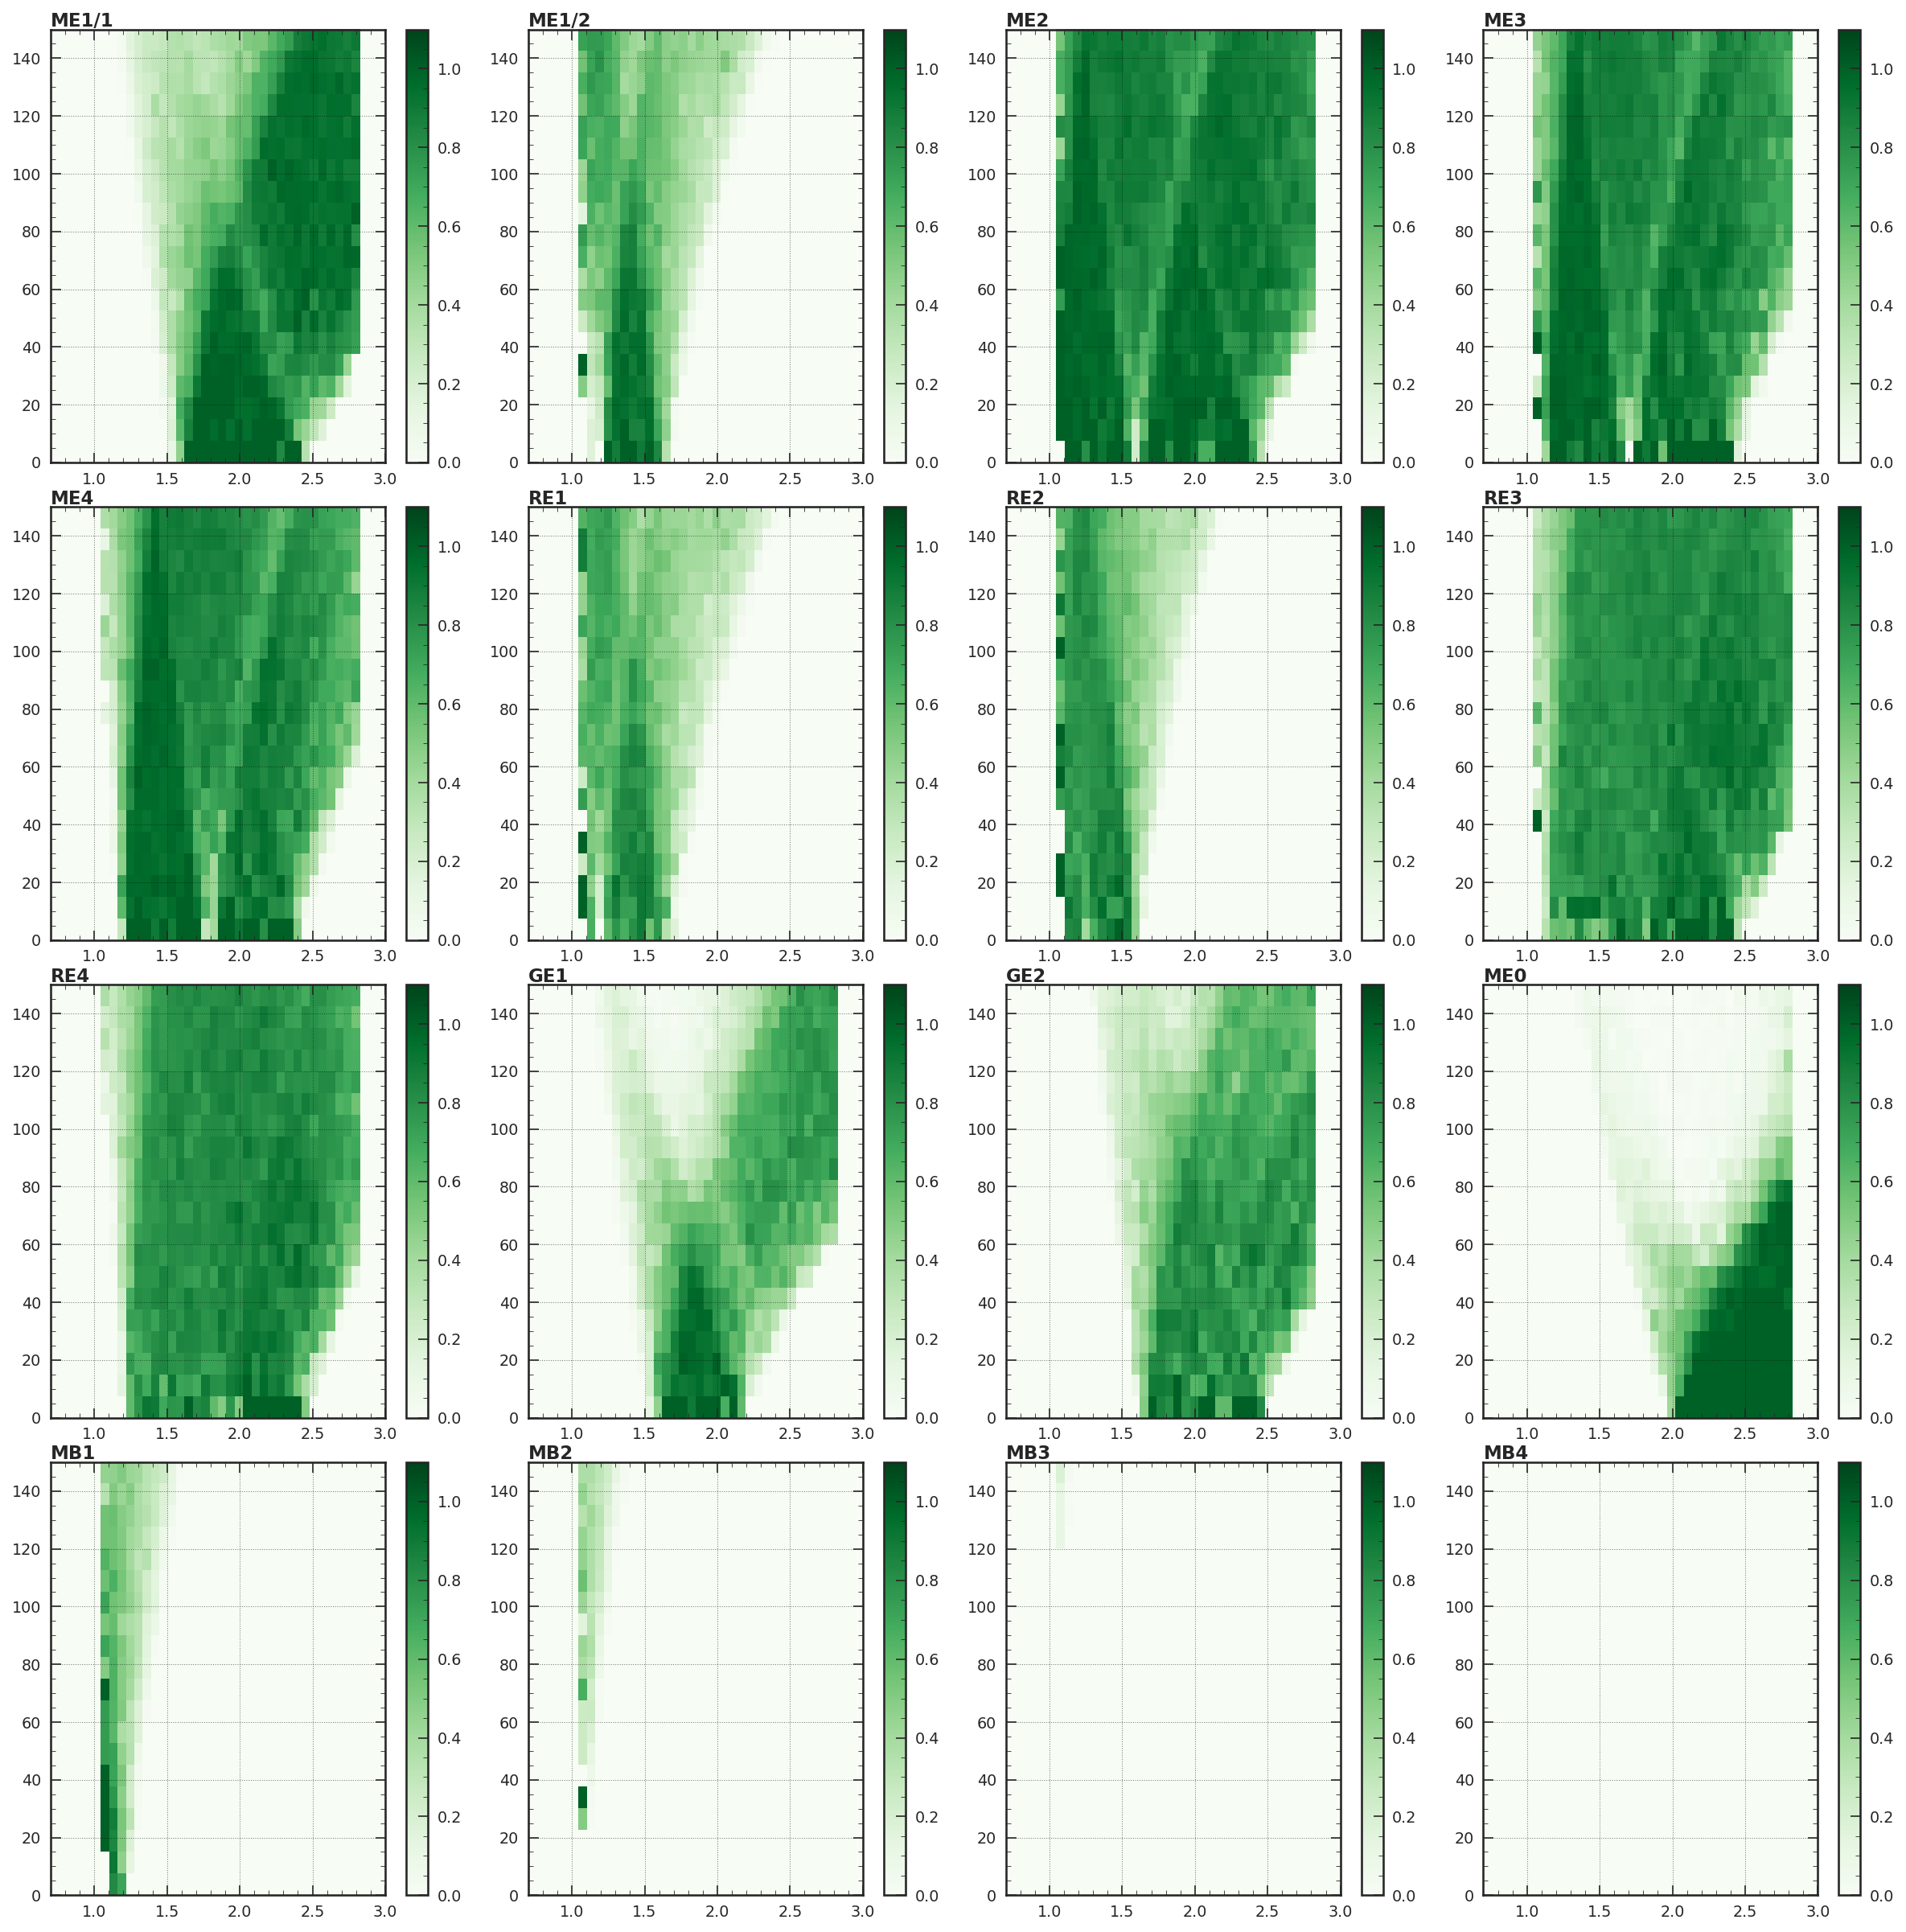

In [60]:
##### 2d Histogram ####

import matplotlib as mpl
def my_hist2d(eff_hist, xedges, yedges, ax, cmap=None, colorbar=False):
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = eff_hist.T.ravel()
  h, edges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=0.0, vmax=1.1)
  if colorbar:
    cb = plt.colorbar(image, ax=ax)#, norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),extend='both')
  return h, edges, yedges, image

fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

# 0 < d0 < 5 for displaced muons
y_eta = out_part_eta.copy()
y_etastar = out_part_etastar.copy()
y_d0 = out_part_d0.copy()
y_r_vtx = out_part_r_vtx.copy()
y_pt = out_part_pt.copy()
x_mask = out_hits.copy().astype(np.bool)

etamin, etamax = 0.7, 3.0
d0min, d0max = 0.0, 150.0
ymin, ymax = 0, 150.0

# y_eta_PU200 = out_part_PU200.copy()
# x_mask_PU200 = out_hits_PU200.copy().astype(np.bool)

for i in xrange(nlayers):
    nbinsx = 20
    if status == 'displaced':
        if eff_mode == 'eta' or eff_mode == 'etastar':
            xmin, xmax = 0.7, 3.0
        elif eff_mode == 'd0':
            xmin, xmax = 0.0, 5.0
        nbinsx = 40
    elif status == 'prompt':
        xmin, xmax = 0.7, 3.0
        nbinsx = 90
    
    rangeshape = [[0.7,3.0],[0.0,150.0]]

    mask = x_mask[...,i]
    valid = ~mask  # valid hits

#     # 1d histograms
#     denom_hist, edges = np.histogram(np.abs(y_etastar), bins=40, range=[0.7,3.0])
#     num_hist, edges = np.histogram(np.abs(y_etastar)[valid], bins=40, range=[0.7,3.0])
#     eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)
#     ydata = eff_hist
#     xdata = (edges[1:] + edges[:-1])/2
    
    # 2d histograms
    denom_hist, xedges, yedges = np.histogram2d(np.abs(y_eta), np.abs(y_r_vtx), bins=(40,20), range=rangeshape)
    num_hist, xedges, yedges = np.histogram2d(np.abs(y_eta)[valid], np.abs(y_r_vtx)[valid], bins=(40,20), range=rangeshape)
#     eff_hist = np.true_divide(num_hist, denom_hist)
    eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

#     if i == 2:
#         print eff_hist
    
    # Styling
    from matplotlib.colors import ListedColormap
    my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
    my_cmap.set_under('w',1)
    
    


    
#     X, Y = np.meshgrid(xedges, yedges)

    ax = axs[i/4,i%4]
#     _ = ax.hist2d(y_etastar[valid], y_d0[valid], bins=(40, 20), range=((etamin, etamax), (d0min,d0max)))
####### Don't forget to uncomment this line for 2d hist #######
    _ = my_hist2d(eff_hist, xedges, yedges, ax=ax, cmap=plt.cm.get_cmap('Greens'), colorbar=True) # USE THIS ONE - 2d hist
#     ax.pcolormesh(X, Y, denom_hist)
    ax.text(0.7,151,stations[i],weight='bold') # 1d and 2d hist
#     ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2) # 1d hist
#     ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.1) # 1d hist

#     for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
#         ax.plot([x,x], [d0min,d0max], '--', color='grey')
# #     for y in [0.95]:  # horizontal lines
# #         ax.plot([xmin,xmax], [y,y], '--', color='grey')
#     ax.set_xlim(etamin,etamax)
#     ax.set_ylim(ymin,ymax)

plt.show()

In [ ]:


if status == 'displaced':
    n = [0.0,20.0,50.0,100.0,150.0]
    titles = ['0 < d0 < 20','20 < d0 < 50','50 < d0 < 100','100 < d0 < 150']

    colors = ['blue','orange','green','red']

    for num in range(4):
        fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)
#         fig.suptitle(titles[num],fontsize=20,y=1.02)

        y_eta = new_out_part[num+1,0].copy()
        x_mask = new_out_hits[num+1,0].copy().astype(np.bool)

        for i in xrange(nlayers):
          if eff_mode == 'd0':
              xmin, xmax = n[num], n[num+1]
          elif eff_mode == 'eta' or eff_mode == 'etastar':
              xmin, xmax = 0.7, 3.0
          ymin, ymax = 0, 1.05

          mask = x_mask[...,i]
          valid = ~mask  # valid hits

          denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
          num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
          eff_hist = np.true_divide(num_hist, denom_hist)

          xdata = (edges[1:] + edges[:-1])/2
          ydata = eff_hist

          ax = axs[i/4,i%4]
          if eff_mode == 'd0':
              ax.text(n[num]+0.85,0.98,stations[i],weight='bold')
          elif eff_mode == 'eta' or eff_mode == 'etastar':
              ax.text(0.85,0.98,stations[i],weight='bold')
          ax.errorbar(xdata, ydata, marker=',', capsize=0, lw=2,color=colors[num])
          ax.fill_between(xdata, 0, ydata, color=colors[num], alpha=0.2)

          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)

          if eff_mode == 'eta' or eff_mode == 'etastar':
              for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
                ax.plot([x,x], [ymin,ymax], '--', color='grey')
              for y in [0.95]:  # horizontal lines
                ax.plot([xmin,xmax], [y,y], '--', color='grey')
              ax.set_xlim(xmin,xmax)
              ax.set_ylim(ymin,ymax)
            
        plt.show()
        

In [ ]:
if status == 'displaced':
    fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

    a = 0.05
    
    if eff_mode == 'd0':
        xmin, xmax = 0, 150.0
    elif eff_mode == 'eta' or eff_mode == 'etastar':
        xmin, xmax = 0.7, 3.0
    ymin, ymax = 0, 1.05

    for num in range(4):

        if num == 0:
            y_eta = out_part1.copy()
            x_mask = out_hits1.copy().astype(np.bool)
        elif num == 1:
            y_eta = out_part2.copy()
            x_mask = out_hits2.copy().astype(np.bool)
        elif num == 2:
            y_eta = out_part3.copy()
            x_mask = out_hits3.copy().astype(np.bool)
        elif num == 3: 
            y_eta = out_part4.copy()
            x_mask = out_hits4.copy().astype(np.bool)




        for i in xrange(nlayers):

          mask = x_mask[...,i]
          valid = ~mask  # valid hits

          denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
          num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
          eff_hist = np.true_divide(num_hist, denom_hist)

          xdata = (edges[1:] + edges[:-1])/2
          ydata = eff_hist

          ax = axs[i/4,i%4]
          ax.text(0.85,0.98,stations[i],weight='bold')
          ax.errorbar(xdata, ydata, marker=',', capsize=0, lw=2)
          ax.fill_between(xdata, 0, ydata, alpha=a)

          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)
          ax.legend([num+1])
        
          for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
            ax.plot([x,x], [ymin,ymax], '--', color='grey')
          for y in [0.95]:  # horizontal lines
            ax.plot([xmin,xmax], [y,y], '--', color='grey')
          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)

    plt.show()